# Filter documents

**Purpose**: Decide if a document should be included for news event clustering (`should_include=True`).<br>
A document should be excluded if any of the following are true:
- `ap_syndicated`: indicates likely AP press copy (from Media Cloud)
- `fetch_error`: indicates an error occurred when scraping the URL (from urlExpander)
- `is_generic_url`: indicates that the URL returned from scraping is likely a homepage (from urlExpander)
- `article_maintext_4_is_empty`: indicates that there's no text to cluster with after text pre-processing
- `article_maintext_4_is_valid_dupe`:
    - Indicates that the article is part of a dupe group and is likely about a specific news event
    - The oldest copy is kept for analysis
    - The other copies are marked for exclusion to avoid inflating the dyadic comparison of clustered news events with extra dyads
- `article_maintext_4_is_generic_dupe`:
    - Indicates that the article is part of a dupe group and likely contains generic boilerplate text
    - All copies are marked for exclusion since they likely aren't about a specific news event
- `article_maintext_4_is_misc_dupe`:
    - Indicates that the article is part of a dupe group but it's unclear if it's a `valid_dupe` or `generic_dupe`
    - Since these could be missed `valid_dupe`s (e.g., the `title` and/or `resolved_url` don't match), it's safer to handle them as `valid_dupe`s than as `generic_dupe`s.
    
**Approach for finding duplicates**:<br>
- Modify INCA's `deduplicate()` function so it can return **all** IDs associated with duplicated documents (i.e., including the very first copy)
- Determine `valid_dupe`, `generic_dupe`, and `misc_dupe` based on:
    - varying the `deduplicate()` function's `check_keys` argument, and 
    - setting a threshold for distinguishing between `generic_dupe` and `misc_dupe`
- In this notebook, the term `dupe` represents a 2-item tuple. It is also referred to as a "dupe group".
    - The first item is a hash-value which is generated based on the specified `check_keys`. ES documents are grouped together based on having the same hash-value.
    - The second item is a list of dictionaries. Each dictionary represents an ES document which is trimmed down to include selected fields only.

**Notebook steps:**
1. Add empty text indicator
2. Add duplicate text indicators
3. Evaluate filter conditions and store result in `should_include` field
4. Summarize dupe categories (tables, plots)
5. Summarize `should_include` and filter conditions (tables, plots)

**Use JupyterLab's 'Table of Contents' to see more detailed (sub)headings*

In [43]:
import datetime
import os
import pandas as pd
from pprint import pprint
import plotnine as p9
%matplotlib inline

In [2]:
inca_processing_dir = os.path.join("..", "..", "data", "02-intermediate", "05-inca-processing")

In [3]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '02-text-should-include', logger_type='main')

- Pre-processing uses the Bulk API through the Python Elasticsearch client.
- Elasticsearch: ["How Big Is Too Big?"](https://www.elastic.co/guide/en/elasticsearch/guide/current/bulk.html#_how_big_is_too_big)
>The entire bulk request needs to be loaded into memory by the node that receives our request, so the bigger the request, the less memory available for other requests. There is an optimal size of bulk request. Above that size, performance no longer improves and may even drop off. The optimal size, however, is not a fixed number. It depends entirely on your hardware, your document size and complexity, and your indexing and search load.
>Fortunately, it is easy to find this sweet spot: Try indexing typical documents in batches of increasing size. When performance starts to drop off, your batch size is too big. A good place to start is with batches of 1,000 to 5,000 documents or, if your documents are very large, with even smaller batches.
>It is often useful to keep an eye on the physical size of your bulk requests. One thousand 1KB documents is very different from one thousand 1MB documents. A good bulk size to start playing with is around 5-15MB in size.

In [4]:
bulksize = 2000

## Import INCA and check doctypes

In [5]:
from inca import Inca
myinca = Inca()
myinca.database.list_doctypes()

2021-11-12 06:08:02,224 - [WARNING] - INCA - (hype_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?
2021-11-12 06:08:02,229 - [WARNING] - INCA - (var_tsa_analysis.py).<module>(21) - $DISPLAY environment variable is not set, trying a different approach. You probably are running INCA on a text console, right?


{'tweets2': 889739,
 'tweets2_url': 285447,
 'foxnews': 63571,
 'breitbart': 39412,
 'dailycaller': 29463,
 'oneamericanews': 23008,
 'washingtonexaminer': 20793,
 'newsmax': 12345,
 'gatewaypundit': 9508,
 'infowars': 6751,
 'vdare': 6545,
 'dailystormer': 4005,
 'rushlimbaugh': 2533,
 'americanrenaissance': 2284,
 'seanhannity': 1232}

In [6]:
from usrightmedia.shared.es_queries import query_doctypes
outlet_doctypes = [
    "americanrenaissance",
    "breitbart",
    "dailycaller",
    "dailystormer",
    "foxnews",
    "gatewaypundit",
    "infowars",
    "newsmax",
    "oneamericanews",
    "rushlimbaugh",
    "seanhannity",
    "vdare",
    "washingtonexaminer",
]

## 1. Add empty text indicator

In [7]:
try:
    docs = myinca.processing.is_empty_text(docs_or_query=query_doctypes(outlet_doctypes),
                                           field="article_maintext_4",
                                           save=True,
                                           new_key="article_maintext_4_is_empty",
                                           action="batch",
                                           bulksize=bulksize,)
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

100%|██████████| 221450/221450 [49:47<00:00, 74.14it/s] 


## 2. Add duplicate text indicators

### 2.1 Shared functions and constants

**See the "Set `generic_dupe` threshold" section for details about how the threshold is set**

In [7]:
generic_dupe_threshold = 15

In [8]:
def extract_outlet_dupe_ids(outlet_dupes,
                            category="valid_dupe",
                            generic_dupe_threshold=generic_dupe_threshold):
    """Based on the dupe category, extract the IDs of documents which should be marked for exclusion.
    
        Args:
            outlet_dupes (list of tuples): the dupe groups associated with a particular outlet
                each tuple is (hashval, list of dicts), where each dict represents a document from ES 
                    - the dict contains selected fields based on INCA's deduplicate function

            category (string): the category of duplication
                "valid_dupe": Used when the dupe group likely represents a valid article which should be included for analysis.
                              The oldest doc should be kept (should_include=True), so it is popped off before returning the IDs.

                "generic_dupe": Used when the dupe group likely contains boilerplate text.
                                All docs within this category should be labeled with should_include=False so all IDs are returned.
                                It is used with group size >= generic_dupe_threshold.

                "misc_dupe": Used when the dupe group is not explicitly classified as "valid_dupe" or as "generic_dupe".
                             Since these may be unidentified "valid dupes" (the doctype and text match, but the title and/or resolved URL don't match)
                             the safer way to handle this category is treat them as "valid_dupe".
                             It is used with group size < generic_dupe_threshold.

         Returns:
             dupe_ids (list of strings): list of duplicate document IDs which should be labeled as dupes
                         
    """
    dupe_ids = []
    for hashval, docs in outlet_dupes:
            docs = sorted(docs,
                           reverse=False,
                           key=lambda k: datetime.datetime.fromisoformat(k["publish_date"]),
                          )
            
            if category=="valid_dupe":
                # don't include the oldest doc in the list of dupe ids
                doc_to_keep = docs.pop(0)
                ids = [d["_id"] for d in docs]
                dupe_ids.extend(ids)
            
            elif (category=="generic_dupe") & (len(docs) >= generic_dupe_threshold):
                ids = [d["_id"] for d in docs]
                dupe_ids.extend(ids)
                
            elif (category=="misc_dupe") & (len(docs) < generic_dupe_threshold):
                # treat it like "valid_dupe"
                doc_to_keep = docs.pop(0)
                ids = [d["_id"] for d in docs]
                dupe_ids.extend(ids)
                
    return dupe_ids

In [59]:
def dupe_group_summary(dict_dupes, category, serial_printout=False):
    """Print the dupe category's stats per outlet.
    
    Args:
        dict_dupes (dict):
            each dict key is an outlet_doctype
            each dict value is a list of dupes
                each dupe is a tuple which represents a group of duplicated documents; (hashval, list of dicts)
                    each dict is an ES doc with selected fields (e.g., _id, doctype, publish_date, article_maintext_4, etc.)
        
        category (str): labels the summary
        
        serial_printout (bool): if True, print out the summary per doctype one-by-one
        
    Returns:
        summary (dataframe)
    
    """
    
    # keep outlet doctypes only
    dict_doctype = {k: v for k,v in myinca.database.list_doctypes().items() if k in outlet_doctypes}
    
    dupe_counts = []
    max_dupe_sizes = []
    doc_counts = []
    doctype_counts = []
    doctype_percents = []

    # stats per outlet
    for outlet, dupes in dict_dupes.items():
        
        # number of dupe groups associated with this outlet
        dupe_count = len(dupes)
        dupe_counts.append(dupe_count)
        
        # max size of dupe group
        dupe_sizes = [len(dupe[1]) for dupe in dupes] if len(dupes) > 0 else [0]
        max_dupe_size =  max(dupe_sizes)
        max_dupe_sizes.append(max_dupe_size)
        
        # number of duped ES documents 
        doc_count = sum(dupe_sizes)
        doc_counts.append(doc_count)
        
        # percent of outlet's ES documents
        doctype_count = dict_doctype[outlet]
        doctype_counts.append(doctype_count)
        doctype_percent = round(doc_count/doctype_count*100, 2)
        doctype_percents.append(doctype_percent)
        
        if serial_printout:
            print(f'''{"="*60}
                    {category}: {outlet}
                    {"-"*30}
                    num of dupe groups: {dupe_count}
                    max size of dupe groups: {max_dupe_size}
                    outlet's dupe docs: {doc_count}
                    outlet's docs: {doctype_count}
                    percent of outlet's docs: {doctype_percent}%
                    ''')
    
    # stats for all outlets
    all_dupe_count = sum(dupe_counts)
    all_max_dupe_size = max(max_dupe_sizes)
    all_doc_count = sum(doc_counts)
    all_doctype_count = sum(doctype_counts)
    all_doctype_percent = round(all_doc_count/all_doctype_count*100, 2)
            
            
    if serial_printout:        
        print(f'''{"="*60}
                    {category}: all
                    {"-"*30}
                    num of dupe groups: {all_dupe_count}
                    max size of dupe groups: {all_max_dupe_size}
                    all outlets' dupe docs: {all_doc_count}
                    all outlets' docs: {all_doctype_count}
                    percent of all outlets' docs: {all_doctype_percent}%
                    ''')

    col_doctypes = outlet_doctypes + ["all"]
    col_category = [category]*len(col_doctypes)
    col_dupe_counts = dupe_counts + [all_dupe_count]
    col_max_dupe_sizes = max_dupe_sizes + [all_max_dupe_size]
    col_doc_counts = doc_counts + [all_doc_count]
    col_doctype_counts = doctype_counts + [all_doctype_count]
    col_doctype_percents = doctype_percents + [all_doctype_percent]
    
    col_data = [col_category, col_doctypes, col_dupe_counts, col_max_dupe_sizes, col_doc_counts, col_doctype_counts, col_doctype_percents]
    col_names = ["category", "doctype", "dupe_count", "max_dupe_size", "doc_count", "doctype_count", "doctype_percent"]
    data = dict(zip(col_names, col_data))
    summary = pd.DataFrame(data)
    
    return summary

In [10]:
def get_example_dupe(dupes, index=0, hide_text=True):
    """
    Args:
        dupes (list of tuples)
        index (int): which dupe to show based on the index position within dupes
        hide_text (bool): if True, don't show 'article_maintext_4'
        
    Returns:
        example (tuple): hashval, documents
        
    """
    if hide_text:
        example = (dupes[index][0], [{k: v for k, v in d.items() if k != 'article_maintext_4'} for d in dupes[index][1]])
        
    else:
        example = (dupes[index][0], [{k: v for k, v in d.items()} for d in dupes[index][1]])
    return example

In [11]:
def show_example_dupes(outlet_dupes, hide_text=True, n_docs=3):
    dupe_count = len(outlet_dupes)
    for idx in range(0, dupe_count):
        print("-"*80)
        docs = get_example_dupe(outlet_dupes, index=idx, hide_text=hide_text)[1]
        print(f"Index {idx}: {len(docs)} docs")
        pprint(docs[0:n_docs])

In [12]:
def filter_dupes(dupes, category, generic_dupe_threshold=generic_dupe_threshold, verbose=False):
    """Filter dupes based on generic_dupe_threshold.
    
    This function is used to help distinguish between "misc_dupe" and "generic_dupe" categories.
    
    Args:
        dupes (list of tuples): should be a list of generic dupe candidates for an outlet
                                each dupe is a tuple which represents a group of duplicated documents
                                (hashval, [dict1, dict2, ...])
                                
        category (string): "generic_dupe", "misc_dupe"
        
        verbose (bool): if True, print key-values for each doc in the dupe group
        
    """
    
    filtered_dupes = []
    for hashval, docs in dupes:
            if category=="generic_dupe":
                if len(docs) >= generic_dupe_threshold:
                    filtered_dupes.append((hashval, docs))
            elif category=="misc_dupe":
                if len(docs) < generic_dupe_threshold:
                    filtered_dupes.append((hashval, docs))
                        
            if verbose:
                print(f"hashval of dupe group: {hashval}")
                print(f"num of docs in dupe group: {len(docs)}")
                pprint([{k: v for k, v in d.items() if k != "article_maintext_4"} for d in docs])
                
    return filtered_dupes

### 2.2 `valid_dupe`

#### 2.2.1 Retrieve documents by outlet from INCA
- A document is considered a `valid_dupe` if it:
    - won't already be excluded due to `ap_syndicated`, `fetch_error`, `is_generic_url`, `article_maintext_4_is_empty`, and 
    - matches 1+ other documents based on `doctype`, `title`, `resolved_url`, and `article_maintext_4`.

In [13]:
def get_valid_dupes(doctype):
    """Retrieve the IDs of ES documents which should be labeled as 'valid_dupe=True'
    """
    
    query = {
            "query": {
                "bool": {
                  "filter": [
                    {
                      "term": {
                        "ap_syndicated": "false"
                      }
                    },
                    {
                      "term": {
                        "fetch_error": "false"
                      }
                    },
                    {
                      "term": {
                        "is_generic_url": "false"
                      }
                    },
                    {
                      "term": {
                        "article_maintext_4_is_empty": "false"
                      }
                    },
                    {
                      "term": {
                        "doctype": doctype
                      }
                    }
                  ]
                }
              }
            }
    
    g = myinca.database.document_generator(query)
    dupes = myinca.database.deduplicate(g,
                                        action="return",
                                        check_keys=["doctype", "title", "resolved_url", "article_maintext_4"],
                                        extra_keys=["url"],
                                        date_field="publish_date")
    return dupes

In [14]:
def get_dict_of_valid_dupes(outlet_doctypes=outlet_doctypes): 
    """Get the list of valid dupes for every outlet.
    
    Args:
        outlet_doctypes (list of strings)
        
    Returns:
        dict_dupes (dict): each key corresponds with an outlet_doctype
                           each value is a list of dupes
    
    """
    dict_dupes = {}
    for doctype in outlet_doctypes:
        dict_dupes[doctype] = get_valid_dupes(doctype)
        
    return dict_dupes

In [15]:
dict_valid_dupes = get_dict_of_valid_dupes(outlet_doctypes=outlet_doctypes)

100%|██████████| 18886/18886 [00:08<00:00, 2307.36it/s]


In [16]:
dupe_group_summary(dict_valid_dupes, category="valid_dupe", serial_printout=False)

,category,doctype,dupe_count,max_dupe_size,doc_count,doctype_count,doctype_percent
0,valid_dupe,americanrenaissance,0,0,0,2284,0.00
1,valid_dupe,breitbart,152,3,305,39412,0.77
2,valid_dupe,dailycaller,467,4,937,29463,3.18
3,valid_dupe,dailystormer,0,0,0,4005,0.00
4,valid_dupe,foxnews,235,8,569,63571,0.90
5,valid_dupe,gatewaypundit,357,3,715,9508,7.52
6,valid_dupe,infowars,48,2,96,6751,1.42
7,valid_dupe,newsmax,4,2,8,12345,0.06
8,valid_dupe,oneamericanews,0,0,0,23008,0.00
9,valid_dupe,rushlimbaugh,196,2,392,2533,15.48


#### 2.2.2 Example

In [17]:
get_example_dupe(dict_valid_dupes['washingtonexaminer'], index=0, hide_text=True)

(b'm.\x8b\x02R\xc8\xb9e\xc5(\xd6\x842\x1d\xd5\xfd',
 [{'_id': 'WashingtonExaminer_564661622',
   'resolved_url': 'http://www.washingtonexaminer.com/cruz-caves-endorses-trump/article/2602712',
   'url': 'http://www.washingtonexaminer.com/cruz-caves-endorses-trump/article/2602712#.V-WQ3kMWYgw.twitter',
   'doctype': 'washingtonexaminer',
   'title': 'Report: Cruz caves, set to endorse Trump',
   'publish_date': '2017-01-08T19:00:00+00:00'},
  {'_id': 'WashingtonExaminer_564746753',
   'resolved_url': 'http://www.washingtonexaminer.com/cruz-caves-endorses-trump/article/2602712',
   'url': 'http://www.washingtonexaminer.com/cruz-caves-endorses-trump/article/2602712?custom_click=rss&utm_source=twitterfeed&utm_medium=twitter',
   'doctype': 'washingtonexaminer',
   'title': 'Report: Cruz caves, set to endorse Trump',
   'publish_date': '2017-01-09T11:55:00+00:00'},
  {'_id': 'WashingtonExaminer_565799655',
   'resolved_url': 'http://www.washingtonexaminer.com/cruz-caves-endorses-trump/articl

#### 2.2.3 Collect the IDs of documents which will be labeled as valid dupes

The oldest copy from each group is not included in the `valid_dupe_ids` list its a valid article for news event clustering.

In [18]:
valid_dupe_ids = []
for outlet_dupes in dict_valid_dupes.values():
    valid_dupe_ids.extend(extract_outlet_dupe_ids(outlet_dupes, category="valid_dupe"))

In [19]:
len(valid_dupe_ids)

3233

#### 2.2.4 Mark the `valid_dupe` IDs in INCA

In [22]:
query_valid_dupe_true = {
                        "query": {
                            "bool": {
                              "filter": [
                                {
                                  "terms": {
                                    "_id": valid_dupe_ids
                                  }
                                },
                                {
                                  "terms": {
                                    "doctype": outlet_doctypes
                                  }
                                }
                              ]
                            }
                          }
                        }

try:
    docs = myinca.processing.is_true_ind(docs_or_query=query_valid_dupe_true,
                                         field="article_maintext_4", # dummy field
                                         save=True,
                                         new_key="article_maintext_4_is_valid_dupe",
                                         action="batch",
                                         bulksize=bulksize,
                                        )
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

100%|██████████| 3233/3233 [00:07<00:00, 405.83it/s] 


In [ ]:
query_valid_dupe_false = {
                          "query": {
                            "bool": {
                              "filter": [
                                {
                                  "terms": {
                                    "doctype": outlet_doctypes
                                  }
                                }
                              ],
                              "must_not": [
                                {
                                  "terms": {
                                    "_id": valid_dupe_ids
                                  }
                                }
                              ]
                            }
                          }
                        }

try:
    docs = myinca.processing.is_false_ind(docs_or_query=query_valid_dupe_false,
                                         field="article_maintext_4", # dummy field
                                         save=True,
                                         new_key="article_maintext_4_is_valid_dupe",
                                         action="batch",
                                         bulksize=bulksize,
                                         )
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

### 2.3 Generic dupe candidates
- These groups are only considered candidates at this step, since they may actually be `valid_dupe` groups which were missed because the title and/or resolved URL did not match.
- Generic dupe candidates will be further split into two categories (`generic_dupe` and `misc_dupe`).

#### 2.3.1 Retrieve documents by outlet from INCA

In [20]:
def get_generic_dupe_candidates(doctype):
    """Get candidates documents for evaluating generic text indicator"""
    query = {
            "query": {
                "bool": {
                  "filter": [
                    {
                      "term": {
                        "ap_syndicated": "false"
                      }
                    },
                    {
                      "term": {
                        "fetch_error": "false"
                      }
                    },
                    {
                      "term": {
                        "is_generic_url": "false"
                      }
                    },
                    {
                      "term": {
                        "article_maintext_4_is_empty": "false"
                      }
                    },
                    {
                      "term": {
                        "article_maintext_4_is_valid_dupe": "false"
                      }
                    },
                    {
                      "term": {
                        "doctype": doctype
                      }
                    }
                  ]
                }
              }
            }
    
    g = myinca.database.document_generator(query)
    dupes = myinca.database.deduplicate(g,
                                        action="return",
                                        check_keys=["doctype", "article_maintext_4"],
                                        extra_keys=["title", "url", "resolved_url"],
                                        date_field="publish_date")
    return dupes

In [21]:
def get_dict_of_generic_dupe_candidates(outlet_doctypes=outlet_doctypes): 
    """Get the list of generic dupe candidates for every outlet.
    
    Args:
        outlet_doctypes (list of strings)
        
    Returns:
        dict_dupes (dict): each key corresponds with an outlet_doctype
                           each value is a list of dupes
    
    """
    dict_dupes = {}
    for doctype in outlet_doctypes:
        dict_dupes[doctype] = get_generic_dupe_candidates(doctype)
        
    return dict_dupes

In [22]:
dict_generic_dupe_candidates = get_dict_of_generic_dupe_candidates(outlet_doctypes=outlet_doctypes)

100%|██████████| 17354/17354 [00:06<00:00, 2861.67it/s]


#### 2.3.2 Example where candidate is a `generic_dupe`

This group is correctly identified as a generic dupe since the text field is identical while the URLs point to different articles (see the `url`, `resolved_url`, and `title` fields). The article text isn't shown due to copyright.

In [23]:
# Generic dupe groups are already sorted from largest to smallest so foxnews_generic_dupes[0] returns the largest generic dupe group
generic_dupe_example = get_example_dupe(dict_generic_dupe_candidates['foxnews'], index=0, hide_text=True)
print(f"The dupe group candidate has {len(generic_dupe_example[1])} docs. Here are a few examples:")
generic_dupe_example[1][0:3]

The dupe group candidate has 648 docs. Here are a few examples:


[{'_id': 'FoxNews_411266985',
  'resolved_url': 'https://www.foxnews.com/category/columns/the-weather-front',
  'url': 'http://weather.blogs.foxnews.com/2016/01/02/flood-waters-continue-to-rise-and-crest-at-record-levels/',
  'doctype': 'foxnews',
  'title': 'Flood waters continue to rise and crest at record levels',
  'publish_date': '2016-01-02T19:25:02+00:00'},
 {'_id': 'FoxNews_542872901',
  'resolved_url': 'https://www.foxnews.com/category/latino',
  'url': 'http://latino.foxnews.com/latino/politics/2016/01/04/first-trump-campaign-tv-ad-airing-tuesday-focuses-on-isis-immigration/',
  'doctype': 'foxnews',
  'title': 'First Trump campaign TV ad airing Tuesday focuses on ISIS, immigration',
  'publish_date': '2016-01-04T12:00:00+00:00'},
 {'_id': 'FoxNews_540642375',
  'resolved_url': 'https://www.foxnews.com/category/latino',
  'url': 'http://latino.foxnews.com/latino/politics/2016/01/04/massive-detentions-wont-stop-migration-to-us-guatemalan-says/',
  'doctype': 'foxnews',
  'titl

#### 2.3.3 Example where the candidate is actually an unidentified `valid dupe`
This dupe is actually a valid article which was duplicated. It was not caught by the `valid dupe` logic because the title and/or resolved_url didn't match.

In [24]:
candidate_hashval_valid_dupe, candidate_docs_valid_dupe = get_example_dupe(dict_generic_dupe_candidates['foxnews'], index=-1, hide_text=True)
print(f"The dupe group candidate has {len(candidate_docs_valid_dupe)} docs:")
candidate_docs_valid_dupe[0:3]

The dupe group candidate has 2 docs:


[{'_id': 'FoxNews_1056846210',
  'resolved_url': 'https://www.foxnews.com/opinion/liz-peek-struggling-dems-need-their-own-donald-trump#930791532-tw%231518629432381',
  'url': 'https://www.foxnews.com/opinion/liz-peek-struggling-dems-need-their-own-donald-trump#930791532-tw#1518629432381',
  'doctype': 'foxnews',
  'title': 'Liz Peek: Struggling Dems need their own Donald Trump | Fox News',
  'publish_date': '2018-02-05T05:00:00+00:00'},
 {'_id': 'FoxNews_797513454',
  'resolved_url': 'https://www.foxnews.com/opinion/liz-peek-struggling-dems-need-their-own-donald-trump',
  'url': 'http://www.foxnews.com/opinion/2018/02/14/liz-peek-struggling-dems-need-their-own-donald-trump.html',
  'doctype': 'foxnews',
  'title': 'Liz Peek: Struggling Dems need their own Donald Trump',
  'publish_date': '2018-02-14T09:00:00+00:00'}]

### 2.4 Set `generic_dupe` threshold

- **The `generic_dupe_threshold` is set to 15 to balance between**:
    - accurately excluding docs with generic boilerplate text, and
    - retaining the oldest copy of a dupe group if the candidate's docs are actually part of an unidentified `valid_dupe` group.


- **Spot-check:**
    - A candidate group is correctly considered a `generic_dupe` if the documents within it are about unrelated news events.
    - The spot-check below shows candidates ranging from 10-30 in size. Most of the candidates do appear to be `generic_dupe`s.
    - One exception is Fox News' hashval `b'[\xc2\x1b\xfd\xe7e\xbc\x10\xd8L\x9f\xd8\x95\x8ai('` regarding an Ethiopian Airlines plane crash.
        - In this case, the 10 `url` values from Media Cloud resulted in the same `resolved_url`.
        - While the `title` differs in terms of alphabetical letters, they are clearly about the same news event. In other words, this is actually a `valid_dupe`.


- **Result of threshold:**
    - The dupe group candidates which meet the threshold will be classified as `generic_dupe`. All copies will be marked for exclusion.
    - The dupe group candidates with fewer documents than the threshold will be classified as `misc_dupe`.
        - Since it's possible that `misc_dupe` groups would (manually) be identifiable as `valid_dupe`s, it's safer to treat them as such. This means that the oldest copy is kept while the more recent copies are excluded. This is safer than classifying them as `generic_dupe`, since that would result in excluding all copies. If it is actually a `generic_dupe`, the impact is still minimized (possibility of 1 extra dyad for a news event).

#### 2.4.1 Spot-check

In [25]:
for doctype, dupe_candidates in dict_generic_dupe_candidates.items():
    print("="*80)
    print(doctype)
    for hashval, docs in dupe_candidates:
        if len(docs) in range(10, 30): # change the range values to spot-check for missed valid dupes
            print(f"-"*80)
            print(f"dupe candidate's hashval: {hashval}")
            print(f"dupe candidate's size: {len(docs)}")
            pprint([{k: v for k, v in d.items() if k != "article_maintext_4"} for d in docs][0:3])

americanrenaissance
breitbart
dailycaller
--------------------------------------------------------------------------------
dupe candidate's hashval: b'xM1\x11\x85*\x15\x1a\xaa,\xd8\x8d\x9b\xf73\xc0'
dupe candidate's size: 17
[{'_id': 'DailyCaller_1491067783',
  'doctype': 'dailycaller',
  'publish_date': '2020-01-10T01:37:04+00:00',
  'resolved_url': 'https://dailycaller.com/2020/01/09/calling-all-patriots-republicans-arent-toeing-trumps-line-iran-which-ones-interview/',
  'title': 'Calling All Patriots: Some Republicans Aren&#8217;t Toeing '
           'Trump&#8217;s Line On Iran. Which Ones Should We Interview?',
  'url': 'https://dailycaller.com/2020/01/09/calling-all-patriots-republicans-arent-toeing-trumps-line-iran-which-ones-interview/'},
 {'_id': 'DailyCaller_1494209335',
  'doctype': 'dailycaller',
  'publish_date': '2020-01-14T03:52:59+00:00',
  'resolved_url': 'https://dailycaller.com/2020/01/13/calling-all-patriots-democrat-trump-2020/',
  'title': 'Calling All Patriots: Wh

### 2.5 Categorize the generic dupe candidates

#### 2.5.1 `generic_dupe`

In [26]:
def get_dict_of_generic_dupes(outlet_doctypes=outlet_doctypes,
                              dict_generic_dupe_candidates=dict_generic_dupe_candidates): 
    """Get the list of generic dupes for every outlet based on filter_dupes().
    
    Args:
        outlet_doctypes (list of strings)
        dict_generic_dupe_candidates (dict)
        
    Returns:
        dict_dupes (dict): each key corresponds with an outlet_doctype
                           each value is a list of dupes
    
    """
    dict_dupes = {}
    for doctype in outlet_doctypes:
        dict_dupes[doctype] = filter_dupes(dict_generic_dupe_candidates[doctype], category="generic_dupe")
        
    return dict_dupes

In [27]:
dict_generic_dupes = get_dict_of_generic_dupes(outlet_doctypes=outlet_doctypes,
                                               dict_generic_dupe_candidates=dict_generic_dupe_candidates)

In [28]:
dupe_group_summary(dict_generic_dupes, category="generic_dupe", serial_printout=False)

,category,doctype,dupe_count,max_dupe_size,doc_count,doctype_count,doctype_percent
0,generic_dupe,americanrenaissance,0,0,0,2284,0.00
1,generic_dupe,breitbart,0,0,0,39412,0.00
2,generic_dupe,dailycaller,1,17,17,29463,0.06
3,generic_dupe,dailystormer,2,404,436,4005,10.89
4,generic_dupe,foxnews,2,648,679,63571,1.07
5,generic_dupe,gatewaypundit,2,288,336,9508,3.53
6,generic_dupe,infowars,3,308,380,6751,5.63
7,generic_dupe,newsmax,0,0,0,12345,0.00
8,generic_dupe,oneamericanews,0,0,0,23008,0.00
9,generic_dupe,rushlimbaugh,0,0,0,2533,0.00


##### 2.5.1.1 `generic_dupe` examples

In [29]:
for outlet_doctype, outlet_generic_dupes in dict_generic_dupes.items():
    print(f"="*80)
    print(outlet_doctype)
    show_example_dupes(outlet_generic_dupes, hide_text=True, n_docs=3)

americanrenaissance
breitbart
dailycaller
--------------------------------------------------------------------------------
Index 0: 17 docs
[{'_id': 'DailyCaller_1491067783',
  'doctype': 'dailycaller',
  'publish_date': '2020-01-10T01:37:04+00:00',
  'resolved_url': 'https://dailycaller.com/2020/01/09/calling-all-patriots-republicans-arent-toeing-trumps-line-iran-which-ones-interview/',
  'title': 'Calling All Patriots: Some Republicans Aren&#8217;t Toeing '
           'Trump&#8217;s Line On Iran. Which Ones Should We Interview?',
  'url': 'https://dailycaller.com/2020/01/09/calling-all-patriots-republicans-arent-toeing-trumps-line-iran-which-ones-interview/'},
 {'_id': 'DailyCaller_1494209335',
  'doctype': 'dailycaller',
  'publish_date': '2020-01-14T03:52:59+00:00',
  'resolved_url': 'https://dailycaller.com/2020/01/13/calling-all-patriots-democrat-trump-2020/',
  'title': 'Calling All Patriots: Which Democrat Will Give Trump The Toughest '
           'Race In 2020? What About The 

#### 2.5.2 `misc_dupe`

In [30]:
def get_dict_of_misc_dupes(outlet_doctypes=outlet_doctypes,
                              dict_generic_dupe_candidates=dict_generic_dupe_candidates): 
    """Get the list of generic dupes for every outlet based on filter_dupes().
    
    Args:
        outlet_doctypes (list of strings)
        dict_generic_dupe_candidates (dict)
        
    Returns:
        dict_dupes (dict): each key corresponds with an outlet_doctype
                           each value is a list of dupes
    
    """
    dict_dupes = {}
    for doctype in outlet_doctypes:
        dict_dupes[doctype] = filter_dupes(dict_generic_dupe_candidates[doctype], category="misc_dupe")
        
    return dict_dupes

In [31]:
dict_misc_dupes = get_dict_of_misc_dupes(outlet_doctypes=outlet_doctypes,
                                         dict_generic_dupe_candidates=dict_generic_dupe_candidates)

In [32]:
dupe_group_summary(dict_misc_dupes, category="misc_dupe", serial_printout=False)

,category,doctype,dupe_count,max_dupe_size,doc_count,doctype_count,doctype_percent
0,misc_dupe,americanrenaissance,21,8,48,2284,2.10
1,misc_dupe,breitbart,4831,4,9933,39412,25.20
2,misc_dupe,dailycaller,1528,6,3228,29463,10.96
3,misc_dupe,dailystormer,2,3,5,4005,0.12
4,misc_dupe,foxnews,1604,11,3399,63571,5.35
5,misc_dupe,gatewaypundit,742,3,1501,9508,15.79
6,misc_dupe,infowars,48,9,113,6751,1.67
7,misc_dupe,newsmax,187,8,386,12345,3.13
8,misc_dupe,oneamericanews,8,2,16,23008,0.07
9,misc_dupe,rushlimbaugh,77,2,154,2533,6.08


##### 2.5.2.1 `misc_dupe` examples: shows a mix of generic dupes and unidentified valid dupes

In [33]:
for outlet_doctype, outlet_misc_dupes in dict_misc_dupes.items():
    print(f"="*80)
    print(outlet_doctype)
    show_example_dupes(outlet_misc_dupes[0:1], hide_text=True, n_docs=3)

americanrenaissance
--------------------------------------------------------------------------------
Index 0: 8 docs
[{'_id': 'AmericanRenaissance_567227146',
  'doctype': 'americanrenaissance',
  'publish_date': '2017-01-14T13:59:52+00:00',
  'resolved_url': 'https://www.amren.com/news/2017/01/comments-week-january-14-2017/',
  'title': 'Comments of the Week, January 14, 2017',
  'url': 'https://www.amren.com/news/2017/01/comments-week-january-14-2017/'},
 {'_id': 'AmericanRenaissance_573341680',
  'doctype': 'americanrenaissance',
  'publish_date': '2017-01-28T14:00:08+00:00',
  'resolved_url': 'https://www.amren.com/news/2017/01/comments-week-january-28-2017/',
  'title': 'Comments of the Week, January 28, 2017',
  'url': 'https://www.amren.com/news/2017/01/comments-week-january-28-2017/'},
 {'_id': 'AmericanRenaissance_579784652',
  'doctype': 'americanrenaissance',
  'publish_date': '2017-02-11T14:00:45+00:00',
  'resolved_url': 'https://www.amren.com/news/2017/02/comments-of-the-

#### 2.5.3 Collect the IDs of documents which will be labeled as generic dupes
Label documents with `article_maintext_4_is_generic_dupe=True` if their dupe group size is >= `generic_dupe_threshold`.

In [34]:
generic_dupe_ids = []
for outlet_dupes in dict_generic_dupes.values():
    generic_dupe_ids.extend(extract_outlet_dupe_ids(outlet_dupes, category="generic_dupe"))

In [35]:
len(generic_dupe_ids)

1975

#### 2.5.4 Mark the `generic_dupe` IDs in INCA

In [144]:
query_generic_dupe_true = {
                        "query": {
                            "bool": {
                              "filter": [
                                {
                                  "terms": {
                                    "_id": generic_dupe_ids
                                  }
                                },
                                {
                                  "terms": {
                                    "doctype": outlet_doctypes
                                  }
                                }
                              ]
                            }
                          }
                        }


try:
    docs = myinca.processing.is_true_ind(docs_or_query=query_generic_dupe_true,
                                         field="article_maintext_4", # dummy field
                                         save=True,
                                         new_key="article_maintext_4_is_generic_dupe",
                                         action="batch",
                                         bulksize=bulksize,)
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

100%|██████████| 1975/1975 [00:00<00:00, 2732.01it/s]


In [147]:
query_generic_dupe_false = {
                          "query": {
                            "bool": {
                              "filter": [
                                {
                                  "terms": {
                                    "doctype": outlet_doctypes
                                  }
                                }
                              ],
                              "must_not": [
                                {
                                  "terms": {
                                    "_id": generic_dupe_ids
                                  }
                                }
                              ]
                            }
                          }
                        }
try:
    docs = myinca.processing.is_false_ind(docs_or_query=query_generic_dupe_false,
                                         field="article_maintext_4", # dummy field
                                         save=True,
                                         new_key="article_maintext_4_is_generic_dupe",
                                         action="batch",
                                         bulksize=bulksize,)
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

100%|██████████| 219475/219475 [1:23:31<00:00, 43.80it/s]


#### 2.5.5 Collect the IDs of documents which will be labeled as misc dupes
Label documents with `article_maintext_4_is_misc_dupe=True` if they are members of "generic_dupe" candidate groups where the size is < `generic_dupe_threshold`.

In [36]:
misc_dupe_ids = []
for outlet_dupes in dict_misc_dupes.values():
    misc_dupe_ids.extend(extract_outlet_dupe_ids(outlet_dupes, category="misc_dupe"))

In [37]:
len(misc_dupe_ids)

11217

#### 2.5.6 Mark the `misc_dupe` IDs in INCA

In [150]:
query_misc_dupe_true = {
                        "query": {
                            "bool": {
                              "filter": [
                                {
                                  "terms": {
                                    "_id": misc_dupe_ids
                                  }
                                },
                                {
                                  "terms": {
                                    "doctype": outlet_doctypes
                                  }
                                }
                              ]
                            }
                          }
                        }

try:
    docs = myinca.processing.is_true_ind(docs_or_query=query_misc_dupe_true,
                                         field="article_maintext_4", # dummy field
                                         save=True,
                                         new_key="article_maintext_4_is_misc_dupe",
                                         action="batch",
                                         bulksize=bulksize,
                                        )
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

100%|██████████| 11217/11217 [03:06<00:00, 60.17it/s] 


In [151]:
query_misc_dupe_false = {
                          "query": {
                            "bool": {
                              "filter": [
                                {
                                  "terms": {
                                    "doctype": outlet_doctypes
                                  }
                                }
                              ],
                              "must_not": [
                                {
                                  "terms": {
                                    "_id": misc_dupe_ids
                                  }
                                }
                              ]
                            }
                          }
                        }
try:
    docs = myinca.processing.is_false_ind(docs_or_query=query_misc_dupe_false,
                                         field="article_maintext_4", # dummy field
                                         save=True,
                                         new_key="article_maintext_4_is_misc_dupe",
                                         action="batch",
                                         bulksize=bulksize,)
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

100%|██████████| 210233/210233 [1:08:33<00:00, 51.10it/s]


## 3. Evaluate filter conditions and store result in `should_include` field

In [154]:
try:
    docs = myinca.processing.should_include(docs_or_query=query_doctypes(outlet_doctypes),
                                            field="article_maintext_4", # dummy field
                                            extra_fields = ["ap_syndicated",
                                                            "fetch_error",
                                                            "is_generic_url",
                                                            "article_maintext_4_is_empty",
                                                            "article_maintext_4_is_valid_dupe",
                                                            "article_maintext_4_is_generic_dupe",
                                                            "article_maintext_4_is_misc_dupe"
                                                           ],
                                            save=True,
                                            new_key="should_include",
                                            action="batch",
                                            bulksize=bulksize,
                                            force=True)
    for doc in docs:
        # runs process on doc
        pass
    
except Exception as e:
    LOGGER.warning(e)

100%|██████████| 221450/221450 [57:46<00:00, 63.88it/s] 


## 4. Summary of dupe categories

### 4.1 Notes for spot-checking `dupe_group_summary()`

The `doc_count` column in the summary represents the number of ES documents which are members of a dupe group. **Not all members are labeled for exclusion in Elasticsearch because:**
- `valid_dupe`: oldest copy is kept, other copies are excluded
- `misc_dupe`: oldest copy is kept, other copies are excluded
- `generic_dupe`: all copies are excluded

- `misc_dupe`, `valid_dupe`: the `doc_count` from the summary should be higher than the total hits returned by an ES query similar to the one below.
    ```
    GET inca_alias/_search?size=0
    {
      "query": {
        "bool": {
          "filter": [
            {
              "term": {
                "article_maintext_4_is_valid_dupe": "true"     # or "article_maintext_4_is_misc_dupe": "true"
              }
            },
            {
              "term": {
                "doctype": "foxnews"
              }
            }
          ]
        }
      }
    }
    ```
- `generic_dupe`: the `doc_count` from the summary should equal the total hits returned by an ES query similar to the one below.
    ```
    GET inca_alias/_search?size=0
    {
      "query": {
        "bool": {
          "filter": [
            {
              "term": {
                "article_maintext_4_is_generic_dupe: "true"
              }
            },
            {
              "term": {
                "doctype": "foxnews"
              }
            }
          ]
        }
      }
    }
    ```

### 4.2 Shared functions

In [67]:
def plot_dupe_summary(smry_dupes=smry_dupes, column='doc_count'):
    """Plot summary of dupes for either the 'doc_count' or 'doctype_percent' field.
    
    Args:
        smry_dupes (dataframe): smry_valid, smry_generic, smry_misc, or smry_dupes
        
    Returns:
        plot (plotnine object)
    
    """
    
    chart = p9.ggplot(smry_dupes, p9.aes(x='doctype', label='doc_count'))
    colors = ['#01665e', '#5ab4ac', '#c7eae5']
    plot = chart
    
    if column=='doc_count':
        points = p9.geom_point(p9.aes(y='doctype_count'), color='#756bb1', shape = "o", alpha = 0.5)
        bars = p9.geom_bar(p9.aes(y=column, fill='category'), stat='identity', alpha = 0.5)
        colors = p9.scale_fill_manual(values=colors)
        labels = p9.labs(x="", y="", title=f"Documents by Dupe Category (Count)")
        scales = p9.scale_y_continuous(limits=(0, max(smry_dupes['doctype_count'])))
        theme = p9.theme_light() + p9.theme(figure_size=(6,4),
                                            legend_box_spacing=0.2,
                                            legend_position="bottom",
                                            legend_title=p9.element_blank())
   
        print(f"Purple points: number of documents in Elasticsearch for the outlet doctype")
        plot = chart + points + bars + colors + labels + scales + theme + p9.coord_flip()
    
    elif column=='doctype_percent':
        bars = p9.geom_bar(p9.aes(y=column, fill='category'), stat='identity', alpha = 0.5)
        # text = p9.geom_text(position= p9.position_stack(vjust=0.5))
        colors = p9.scale_fill_manual(values=colors)
        labels = p9.labs(x="", y="", title=f"Documents by Dupe Category (Percent)")
        scales = p9.scale_y_continuous(breaks=range(0,110,10), limits=(0, 100))
        theme = p9.theme_light() + p9.theme(figure_size=(6,4),
                                            legend_box_spacing=0.2,
                                            legend_position="bottom",
                                            legend_title=p9.element_blank())
        
        plot = chart + bars + colors + labels + scales + theme + p9.coord_flip()

    return plot

### 4.3 Make summaries

In [40]:
# summaries for different dupe categories
smry_valid = dupe_group_summary(dict_valid_dupes, category="valid_dupe", serial_printout=False)
smry_generic = dupe_group_summary(dict_generic_dupes, category="generic_dupe", serial_printout=False)
smry_misc = dupe_group_summary(dict_misc_dupes, category="misc_dupe", serial_printout=False)

# combine the summaries
smry_dupes = pd.concat([smry_valid, smry_generic, smry_misc]).reset_index(drop=True)

# due to p9.coord_flip(), the outlets appear in reverse order
# custom sort so the outlets appear to the user in alphabetical order
smry_dupes['doctype'] = pd.Categorical(smry_dupes['doctype'],
                                       categories=sorted(list(set(smry_dupes['doctype'])), reverse=True), ordered=True)

### 4.4 Plots

Purple points: number of documents in Elasticsearch for the outlet doctype


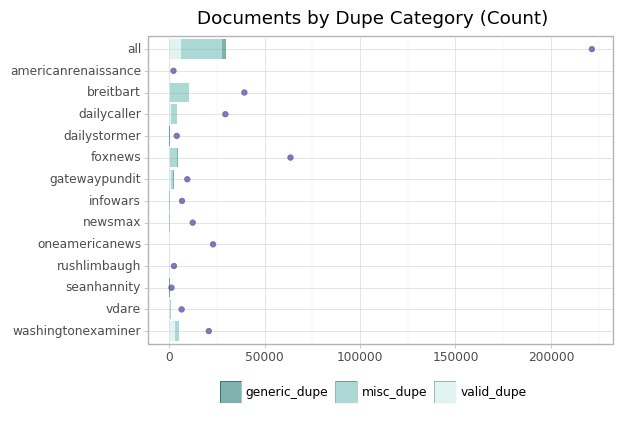

<ggplot: (8752261213248)>

In [44]:
plot_dupe_summary(smry_dupes=smry_dupes, column='doc_count')

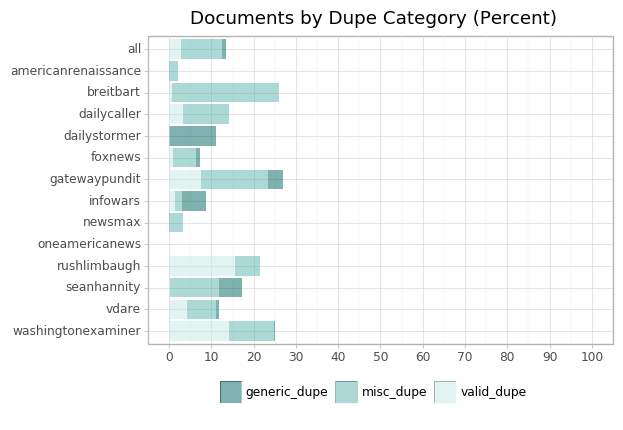

<ggplot: (8752261071065)>

In [45]:
plot_dupe_summary(smry_dupes=smry_dupes, column='doctype_percent')

## 5. summaries of `should_include` and filter conditions

### 5.1 Get an Elasticsearch client

In [47]:
es = myinca.database._client
es_index = myinca.database._elastic_index

### 5.2 Shared functions

In [48]:
def query_agg_bool_field_by_outlet(field):
    """ES aggregate query by outlet doctype.
    
    Args:
        field (str): which boolean field to count True and False instances of
        
    Returns:
        ES query
    
    """
    query = {
              "size": 0,
              "query": {
                "terms": {
                  "doctype": [
                    "americanrenaissance",
                    "breitbart",
                    "dailycaller",
                    "dailystormer",
                    "foxnews",
                    "gatewaypundit",
                    "infowars",
                    "newsmax",
                    "oneamericanews",
                    "rushlimbaugh",
                    "seanhannity",
                    "vdare",
                    "washingtonexaminer"
                  ]
                }
              },
              "aggs": {
                field: {
                  "terms": {
                    "field": "doctype",
                    "order": {
                      "_key": "asc"
                    },
                    "size": 13
                  },
                  "aggs": {
                    "false": {
                      "filter": {
                        "term": {
                          field: "false"
                        }
                      }
                    },
                    "true": {
                      "filter": {
                        "term": {
                          field: "true"
                        }
                      }
                    }
                  }
                }
              }
            }

    return query

In [49]:
def agg_bool_field_by_outlet(field):
    """Summarize a boolean field bucketed by outlet
    
    Args:
        field (str): field name
        
    Returns:
        df (dataframe): summary of boolean field
    
    """
    
    result = es.search(index=es_index, body=query_agg_bool_field_by_outlet(field))
    buckets = result["aggregations"][field]["buckets"]
    
    flattened_buckets = []
    for bucket in buckets:
        """Flatten each bucket

        Before:
            [{'key': 'americanrenaissance',
              'doc_count': 2284,
              'true': {'doc_count': 26},
              'false': {'doc_count': 2258}},
              ...
            ]
            
        After:
            [{'key': 'americanrenaissance',
            'doc_count': 2284,
            'true': 26,
            'false': 2258},
            ...
            ]
        """
        flat = {}
        for k,v in bucket.items():
            if k in ['true', 'false']:
                flat[k] = v['doc_count']
            else:
                flat[k] = v
        flattened_buckets.append(flat)
        
    df = pd.DataFrame(flattened_buckets)
    df = df.rename(columns={'key': 'doctype',
                            'doc_count': 'doctype_count',
                            'true': 'true_count',
                            'false': 'false_count'})
    df["es_field"] = [field]*len(df)
    df["true_percent"] = df['true_count']/df['doctype_count']*100
    df["false_percent"] = df['false_count']/df['doctype_count']*100
    df = df[["es_field", 'doctype','doctype_count', 'true_count', 'false_count', 'true_percent', 'false_percent']]
    
    return df

In [50]:
def plot_bool_summary(bool_field='should_include', column='true_count'):
    """Plot summary of a boolean field.
    
    Args:
        smry_bool (dataframe)
        field (str): 'true_count' or 'true_percent'
        
    Returns:
        plot (plotnine object)
    
    """
    
    smry = bool_summaries[bool_field]
    
    # to make the bar chart horizontal, p9.coord_flip() is used which makes the outlets appear in reverse order
    # custom sort the outlets so they appear to the user in alphabetical order
    smry['doctype'] = pd.Categorical(smry['doctype'],
                                     categories=sorted(list(set(smry['doctype'])),
                                                      reverse=True),
                                     ordered=True)
   
    # setup the basic chart
    chart = p9.ggplot(smry, p9.aes(x='doctype', label='doctype_count'))
    
    # for bar(s)
    colors = ['#5ab4ac']
    
    if column=='true_count':
        points = p9.geom_point(p9.aes(y='doctype_count'), color='#756bb1', shape = "o", alpha = 1)
        bars = p9.geom_bar(p9.aes(y=column, fill='es_field'), stat='identity', alpha = 0.5)
        colors = p9.scale_fill_manual(values=colors)
        labels = p9.labs(x="", y="", title=f"Documents by Bool Category (Count)")
        scales = p9.scale_y_continuous(limits=(0, max(smry_dupes['doctype_count'])))
        theme = p9.theme_light() + p9.theme(figure_size=(6,4),
                                            legend_position="bottom",
                                            legend_box_spacing=0.2,
                                            legend_title=p9.element_blank())
        
        print(f"Purple points: number of documents in Elasticsearch for the outlet doctype")
        plot = chart + points + bars + colors + labels + scales + theme + p9.coord_flip()
    
    elif column=='true_percent':
        bars = p9.geom_bar(p9.aes(y=column, fill='es_field'), stat='identity', alpha = 0.5)
        colors = p9.scale_fill_manual(values=colors)
        labels = p9.labs(x="", y="", title=f"Documents by Bool Category (Percent)")
        scales = p9.scale_y_continuous(breaks=range(0,110,10), limits=(0, 100))
        theme = p9.theme_light() + p9.theme(figure_size=(6,4),
                                            legend_position="bottom",
                                            legend_box_spacing=0.2,
                                            legend_title=p9.element_blank())
        
        plot = chart + bars + colors + labels + scales + theme + p9.coord_flip()

    return plot

In [51]:
booleans = ['should_include', 'ap_syndicated', 'fetch_error', 'is_generic_url',
            'article_maintext_4_is_empty', 'article_maintext_4_is_valid_dupe', 
            'article_maintext_4_is_generic_dupe', 'article_maintext_4_is_misc_dupe']

In [52]:
def get_boolean_summaries(booleans=booleans):
    summaries = {}
    for boolean in booleans:
        summaries[boolean] = agg_bool_field_by_outlet(boolean)
    return summaries

### 5.3 Make summaries

In [53]:
bool_summaries = get_boolean_summaries(booleans=booleans)

### 5.4 Plots

should_include
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


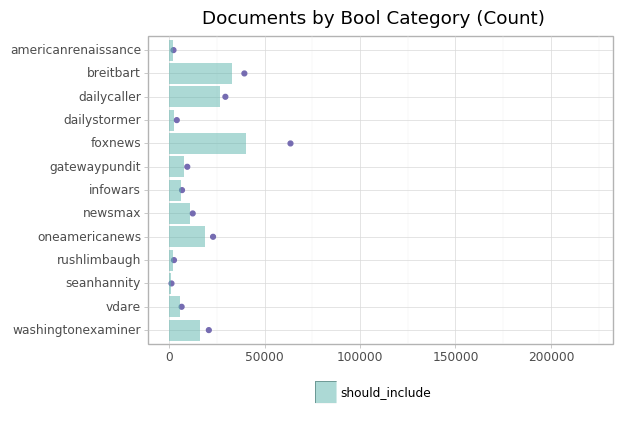

<ggplot: (8752261134891)>

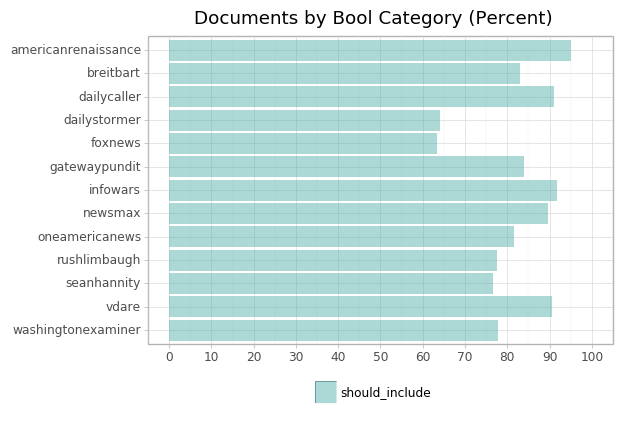

<ggplot: (8752255324094)>

ap_syndicated
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


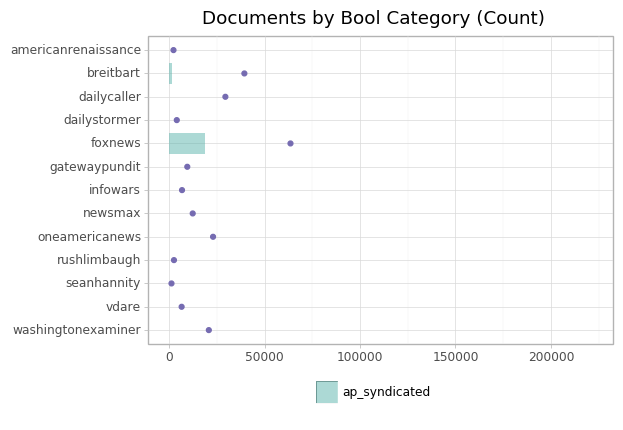

<ggplot: (8752255191595)>

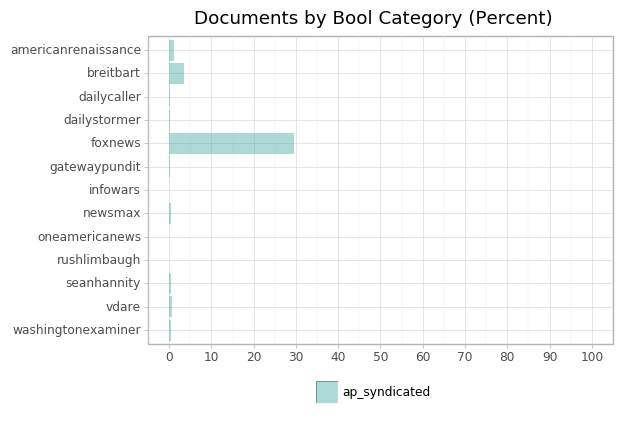

<ggplot: (8752255327257)>

fetch_error
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


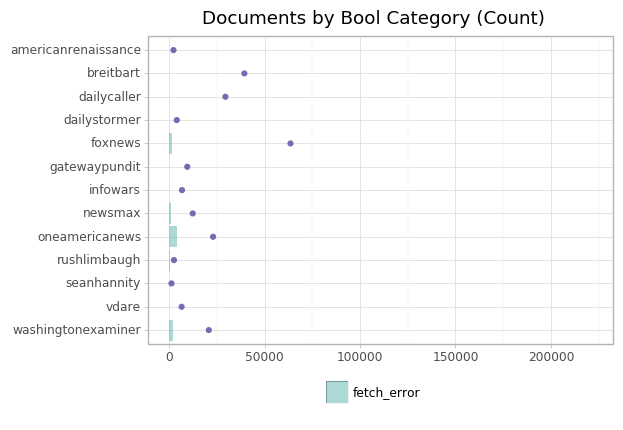

<ggplot: (8752261131261)>

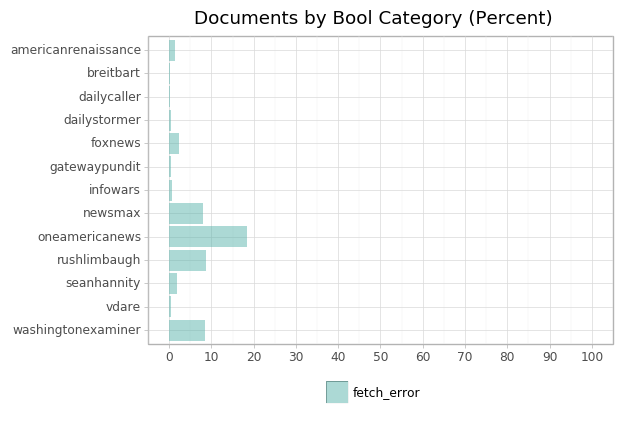

<ggplot: (8752248018354)>

is_generic_url
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


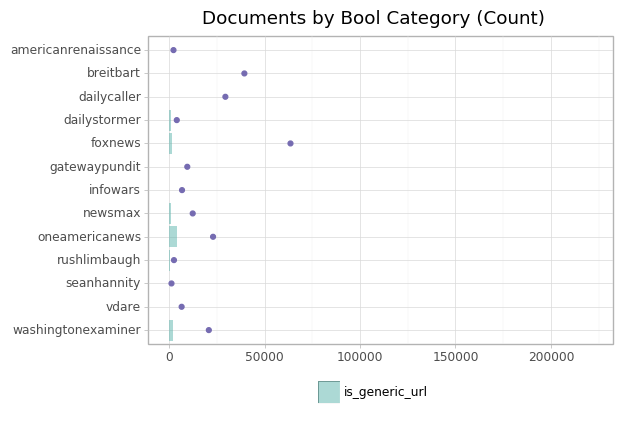

<ggplot: (8752258248852)>

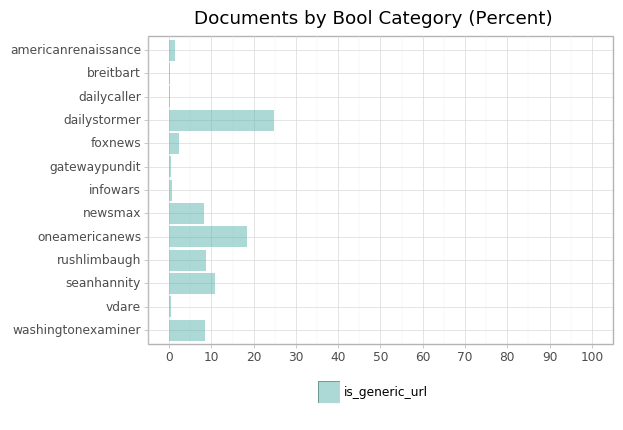

<ggplot: (8752255191622)>

article_maintext_4_is_empty
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


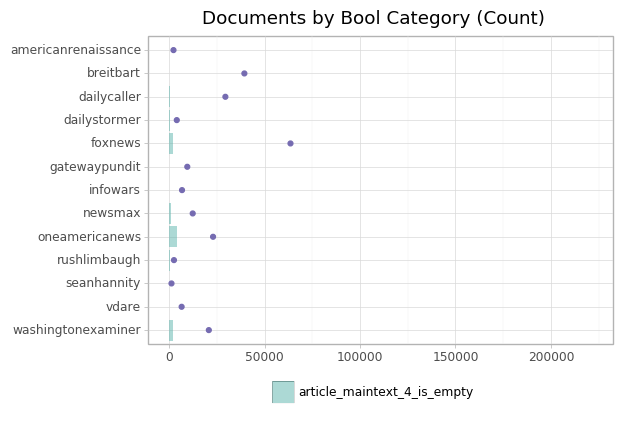

<ggplot: (8752248145869)>

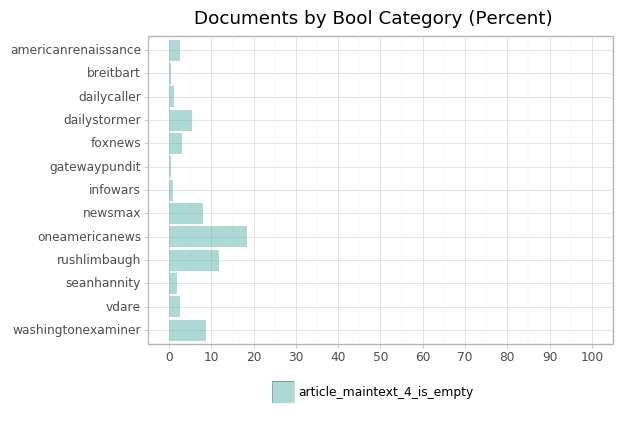

<ggplot: (8752261279741)>

article_maintext_4_is_valid_dupe
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


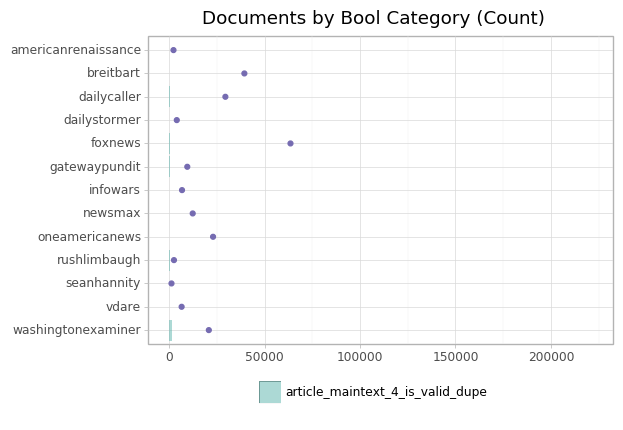

<ggplot: (8752266785669)>

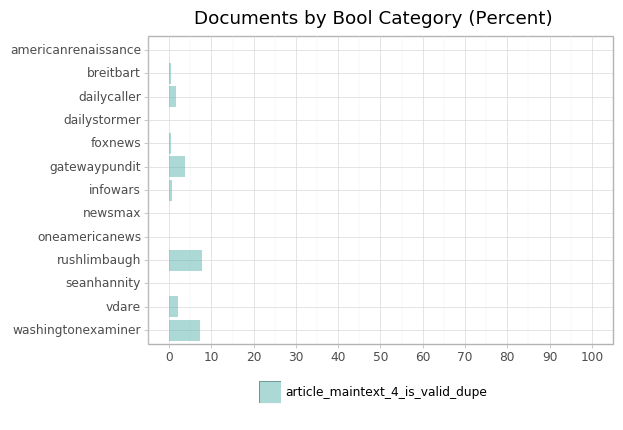

<ggplot: (8752247356974)>

article_maintext_4_is_generic_dupe
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


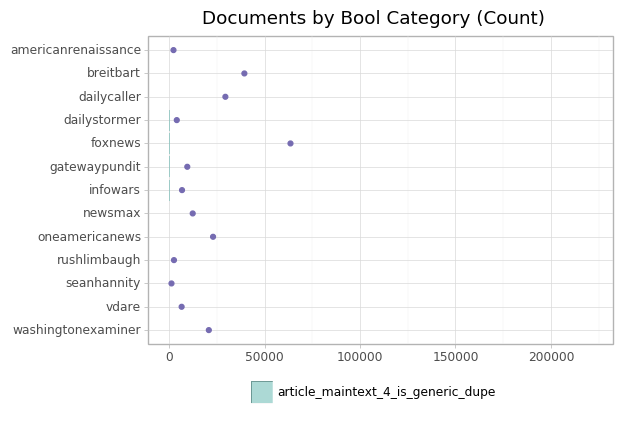

<ggplot: (8752258342413)>

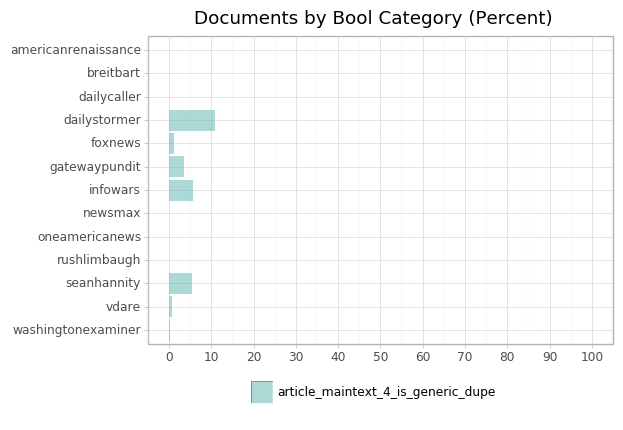

<ggplot: (8752255151520)>

article_maintext_4_is_misc_dupe
--------------------------------------------------------------------------------
Purple points: number of documents in Elasticsearch for the outlet doctype


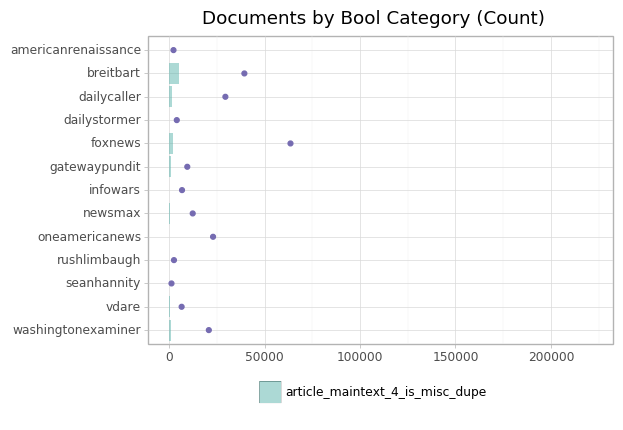

<ggplot: (8752266665482)>

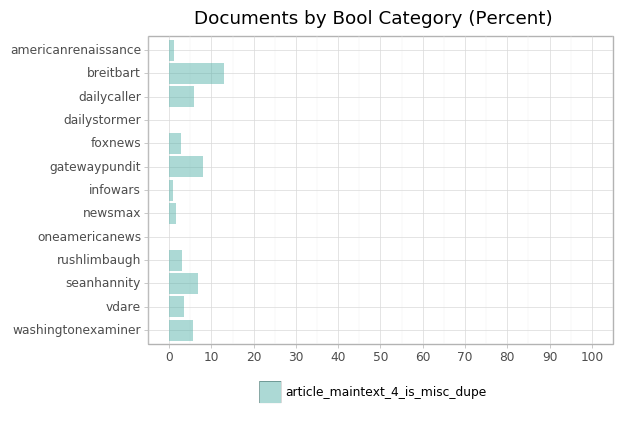

<ggplot: (8752267312481)>

In [68]:
for bool_field in booleans:
    print("="*80)
    print(bool_field)
    print("-"*80)
    display(plot_bool_summary(bool_field=bool_field, column='true_count'))
    display(plot_bool_summary(bool_field=bool_field, column='true_percent'))